In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src import train, generate, eval
from src.train import make_inference_model
from src.pipeline_util import load_bnn
from src.modules.config import read_config
import src.modules.plots as plots
from src.modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine
import json

In [3]:
BASE_DIR = "../tests/sanity_check"
PROFILE = "tyxe-test-gamma"

#BASE_DIR = "../tests/dataset-tests/sineasy10-10k-s03"
#PROFILE = "sineasy10-3x64-s03"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

config["EPOCHS"] = "200"
config["DEVICE"] = "cpu"
config["RERUNS"] = "1"
config["HIDDEN_FEATURES"] = "[32, 32]"

dataset_config["DATA_FUNC"] = "sinusoidal"
dataset_config["SIGMA"] = "0.1"

====== Generating profile sin-(10,20)-10k ======
Train: (-10, 10)
Y-space: -1.8470730182375492 - 1.757711729724389
In Domain: (-10, 10)
Y-space: -1.7689647359468994 - 1.6668478296553313
Out Domain: (-20, 20)
Y-space: -1.583897416334067 - 1.8988115688755396


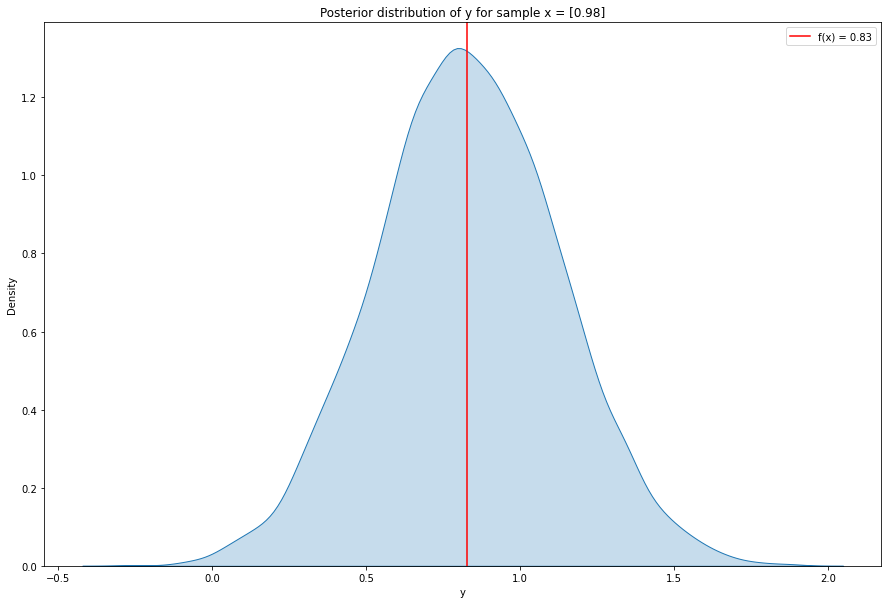

In [5]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [6]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test = torch.vstack((x_test_in_domain, x_test_out_domain))
y_test = torch.vstack((y_test_in_domain, y_test_out_domain))
print(x_test.shape, y_test.shape)

torch.Size([2000, 1]) torch.Size([2000, 1])


In [7]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([2000, 1]) torch.Size([2000, 1])


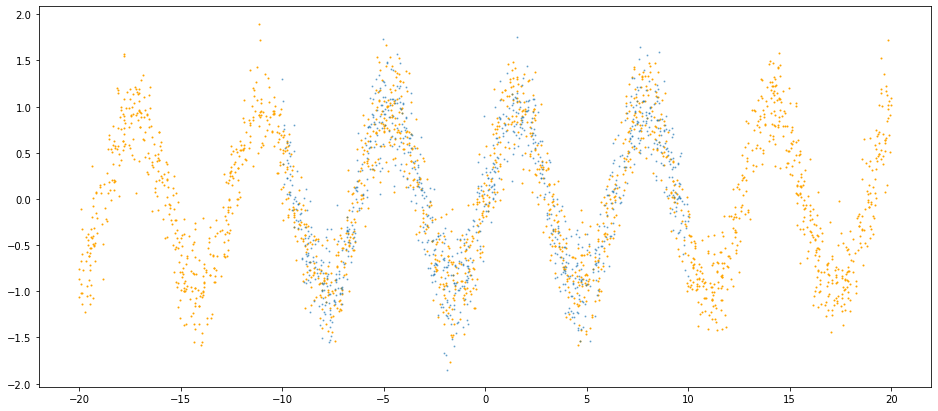

In [8]:
if dataset_config["X_DIM"] == "1":
    fig, ax = plt.subplots(figsize=(16, 7))
    plt.scatter(x_test.squeeze(), y_test, color="orange", s=1)
    plt.scatter(x_train.squeeze(), y_train, s=1, alpha=0.5)


In [9]:
if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    train.train(config, dataset_config, f"{BASE_DIR}", reruns=config.getint("RERUNS"))

torch.Size([128, 1]) torch.Size([128, 1])
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic_gamma PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 1.0 GUIDE_SCALE: 0.01 TRAIN_SIZE: 1000
Initial parameters:
net_guide.net.0.weight.loc torch.Size([32, 1]) Parameter containing:
tensor([[-0.2259],
        [-0.2999],
        [-0.1256],
        [-0.0541],
        [-0.0280],
        [ 0.3677],
        [ 0.2378],
        [ 0.1695],
        [-0.1055],
        [ 0.2429],
        [ 0.2247],
        [-0.6575],
        [-0.0087],
        [ 0.3453],
        [-0.0394],
        [-0.1435],
        [-0.2045],
        [-0.0128],
        [-0.0563],
        [-0.1397],
        [-0.3471],
        [-0.2629],
        [ 0.1740],
   

In [10]:
params = pyro.get_param_store()
params.keys()

dict_keys(['net_guide.net.0.weight.loc', 'net_guide.net.0.weight.scale', 'net_guide.net.0.bias.loc', 'net_guide.net.0.bias.scale', 'net_guide.net.2.0.weight.loc', 'net_guide.net.2.0.weight.scale', 'net_guide.net.2.0.bias.loc', 'net_guide.net.2.0.bias.scale', 'net_guide.net.3.weight.loc', 'net_guide.net.3.weight.scale', 'net_guide.net.3.bias.loc', 'net_guide.net.3.bias.scale', 'likelihood_guide.likelihood._scale.loc', 'likelihood_guide.likelihood._scale.scale'])

In [11]:
bnn = make_inference_model(config, dataset_config)
bnn = load_bnn(bnn, config, f"{BASE_DIR}/models/{NAME}/checkpoint_1.pt")

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic_gamma PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 1.0 GUIDE_SCALE: 0.01 TRAIN_SIZE: 1000
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3531)
Loaded SVI model from ../tests/sanity_check/models/tyxe-test/checkpoint_1.pt


In [12]:
preds2 = bnn.predict(x_test, num_predictions=100, aggregate=False)

Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3481)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3483)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3498)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3498)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3453)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3446)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3546)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3455)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3535)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3470)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3460)
Parameter containing:
tensor(-1.

In [13]:
preds2[:, 0]

tensor([[0.9107],
        [0.6277],
        [0.8848],
        [0.6913],
        [0.7265],
        [0.5092],
        [0.7117],
        [0.7331],
        [0.7068],
        [0.8089],
        [0.5885],
        [0.5865],
        [0.5640],
        [0.8159],
        [0.6813],
        [0.6051],
        [0.6251],
        [0.8287],
        [0.7437],
        [0.7725],
        [0.8356],
        [0.7087],
        [0.5046],
        [0.7352],
        [0.6225],
        [0.6743],
        [0.5613],
        [0.9685],
        [0.6673],
        [0.7594],
        [0.9287],
        [0.7764],
        [0.6901],
        [0.7514],
        [0.6623],
        [0.6675],
        [0.8388],
        [0.7856],
        [0.6363],
        [0.8398],
        [0.6363],
        [0.7688],
        [0.6119],
        [0.6062],
        [0.8126],
        [0.8431],
        [0.6837],
        [0.7358],
        [0.7966],
        [0.8130],
        [0.6713],
        [0.7481],
        [0.8138],
        [0.9089],
        [0.6749],
        [0

In [14]:
bnn

VariationalBNN(
  (net): PyroSequential(
    (0): PyroLinear(in_features=1, out_features=32, bias=True)
    (1): PyroReLU()
    (2): PyroSequential(
      (0): PyroLinear(in_features=32, out_features=32, bias=True)
      (1): PyroReLU()
    )
    (3): PyroLinear(in_features=32, out_features=1, bias=True)
  )
  (net_guide): AutoNormal(
    (net): PyroModule(
      (0): PyroModule(
        (weight): PyroModule()
        (bias): PyroModule()
      )
      (2): PyroModule(
        (0): PyroModule(
          (weight): PyroModule()
          (bias): PyroModule()
        )
      )
      (3): PyroModule(
        (weight): PyroModule()
        (bias): PyroModule()
      )
    )
  )
  (likelihood): HomoskedasticGaussian()
  (likelihood_guide): AutoNormal(
    (likelihood): PyroModule(
      (_scale): PyroModule()
    )
  )
)

In [15]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)
p = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=False)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3497)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3450)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3442)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3502)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3522)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3484)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3453)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3455)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3524)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3487)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3425)
Parameter containing:
tensor(-1.

In [16]:
print(means[0])
print(p[:, 0].mean())

tensor([8.0310])
tensor(8.0170)


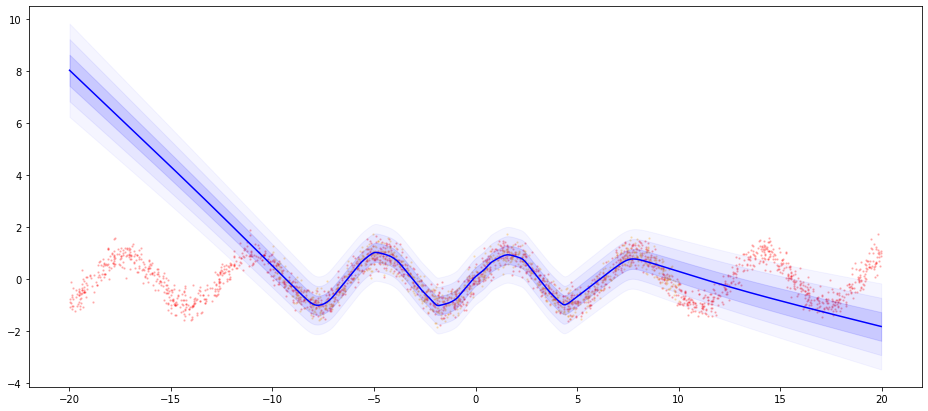

In [17]:
if dataset_config["X_DIM"] == "1":
    fig, ax = plt.subplots(figsize=(16, 7))
    plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
    plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
    plt.plot(x_test[test_sort], means, color="blue")
    #plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
    for c in range(1, 4):
        plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3456)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3403)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3473)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3437)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3552)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3524)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3517)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3449)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3416)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3504)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3476)
Parameter containing:
tensor(-1.

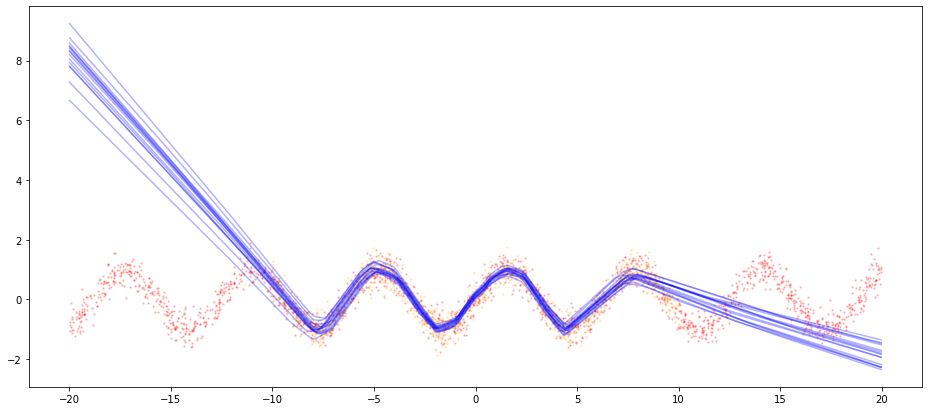

In [18]:
if dataset_config["X_DIM"] == "1":
    sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=15, aggregate=False)
    fig, ax = plt.subplots(figsize=(16, 7))
    plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
    plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
    for yhat in sampled_predictions:
        plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [19]:

if not os.path.exists(f"{BASE_DIR}/results"):
            os.mkdir(f"{BASE_DIR}/results")           
eval.eval(config, dataset_config, f"{BASE_DIR}", bnn=None)

data samples:  (1000, 1000)
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic_gamma PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 1.0 GUIDE_SCALE: 0.01 TRAIN_SIZE: 1000
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3590)
Loaded SVI model from ../tests/sanity_check/models/tyxe-test/checkpoint_1.pt
using device: cpu
====== evaluating profile tyxe-test - 1 ======
pred samples:  (1000, 1000)
Evaluating train...
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3525)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3505)
Parameter containing:
tensor(-1.0566, requires_grad=True)
tensor(0.0162)
tensor(0.3464)
P

In [20]:
profiles= [PROFILE]

colors = ["green"]

names = [configs[p]["NAME"] for p in profiles]

In [21]:
from IPython.display import display, HTML

train_stats = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/train_stats_1.json", "r") as f:
        train_stats[name] = json.load(f)

results = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/results_1.json", "r") as f:
        results[name] = json.load(f)

# Load posterior samples
posterior_samples = {}
for p in profiles:
    name = configs[p]["NAME"]
    # Load posterior samples
    train = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/train_samples_1.npy")
    test = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_samples_1.npy")
    test_in_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_in_domain_samples_1.npy")
    test_out_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_out_domain_samples_1.npy")

    posterior_samples[name] = {
        "train": train,
        "test": test,
        "test_in_domain": test_in_domain,
        "test_out_domain": test_out_domain
    }

In [22]:
#Generate table for rmse
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train RMSE", "In domain RMSE", "Out domain RMSE"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train RMSE": results[name]["train"]["error"]["rmse"],
        "In domain RMSE": results[name]["in_domain"]["error"]["rmse"],
        "Out domain RMSE": results[name]["out_domain"]["error"]["rmse"],
        "Likelihood_std": train_stats[name]["likelihood"]["mean"]
    }, ignore_index=True)

display(table)
print()

#Generate table for mae
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train MAE", "In domain MAE", "Out domain MAE"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train MAE": results[name]["train"]["error"]["mae"],
        "In domain MAE": results[name]["in_domain"]["error"]["mae"],
        "Out domain MAE": results[name]["out_domain"]["error"]["mae"],
        "Likelihood_std": train_stats[name]["likelihood"]["mean"]
    }, ignore_index=True)

display(table)
print()

#Generate table for log likelihood
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train log likelihood", "In domain log likelihood", "Out domain log likelihood"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train log likelihood": results[name]["train"]["error"]["loglikelihood"],
        "In domain log likelihood": results[name]["in_domain"]["error"]["loglikelihood"],
        "Out domain log likelihood": results[name]["out_domain"]["error"]["loglikelihood"],
        "Likelihood_std": train_stats[name]["likelihood"]["mean"]
    }, ignore_index=True)

display(table)

,Name,Likelihood_std,Train RMSE,In domain RMSE,Out domain RMSE
0,tyxe-test,0.348213,0.312285,0.340393,3.491449


,Name,Likelihood_std,Train MAE,In domain MAE,Out domain MAE
0,tyxe-test,0.348213,0.245404,0.26914,2.609941


,Name,Likelihood_std,Train log likelihood,In domain log likelihood,Out domain log likelihood
0,tyxe-test,0.348213,-0.27915,-0.342643,-21.842796


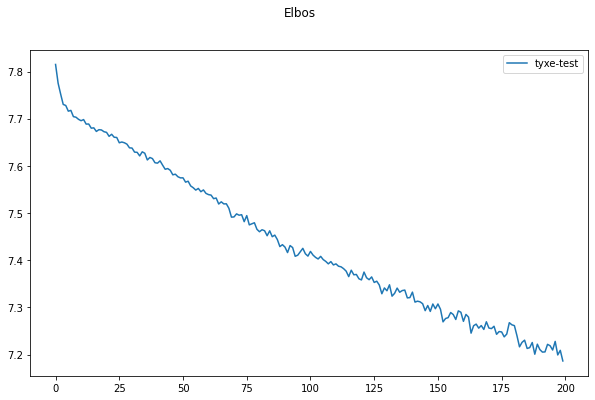

In [23]:
if config["INFERENCE_TYPE"] != "nn":
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Elbos")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        elbos = np.log(train_stats[name]["elbos"])
        ax.plot(elbos, label=name)
    ax.legend()
    plt.show()
else:
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("MSE loss")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        elbos = np.log(train_stats[name]["loss"])
        ax.plot(elbos, label=name)
    ax.legend()
    plt.show()


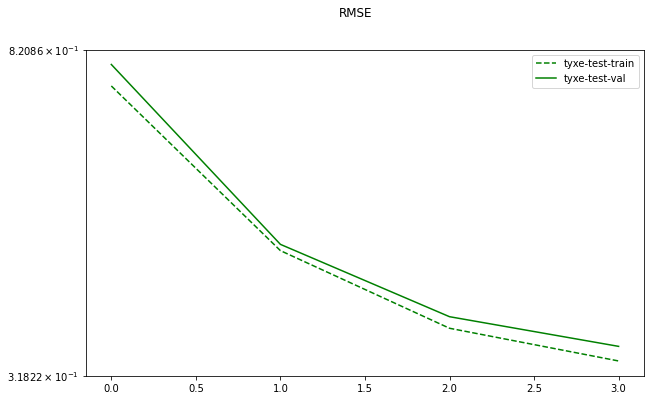

In [24]:
if config["INFERENCE_TYPE"] != "nn":
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("RMSE")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        te = train_stats[name]["train_rmse"]
        ax.plot(te, '--', label=f"{name}-train", color=colors[i])
        ve = train_stats[name]["val_rmse"]
        ax.plot(ve, label=f"{name}-val", color=colors[i])
        ax.set_yscale('symlog', base=10)
    ax.legend()
    plt.show()

/tmp/ipykernel_532509/1143041382.py:10: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('symlog', basey=10)


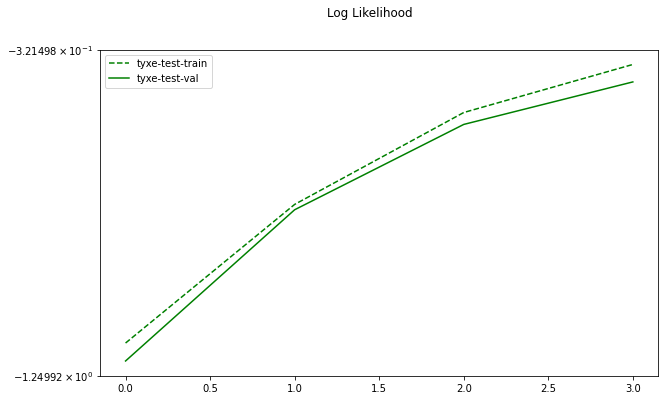

In [25]:
if config["INFERENCE_TYPE"] != "nn":
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Log Likelihood")
    for i, p in enumerate(profiles):
        name = configs[p]["NAME"]
        tll = train_stats[name]["train_ll"]
        ax.plot(tll, '--', label=f"{name}-train", color=colors[i])
        vll = train_stats[name]["val_ll"]
        ax.plot(vll, label=f"{name}-val", color=colors[i])
        ax.set_yscale('symlog', basey=10)
    ax.legend()
    plt.show()

In [26]:
name1 = configs[profiles[0]]["NAME"]
data_samples = {
    "train_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_x.npy"),
    "test_in_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_x.npy"),
    "test_out_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_x.npy"),
    #"test_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_x.npy"),
    "train_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_dist_samples.npy"),
    "test_in_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_dist_samples.npy"),
    "test_out_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_dist_samples.npy"),
    #"test_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_dist_samples.npy"),
}